# Clustering (Unsupervised): U.S. Census ACS Demographic Segmentation

## Project Overview

This project focuses on using **unsupervised learning** to find natural groups (clusters) within U.S. Census data.  
We’ll apply two powerful clustering algorithms — **K-Means** and **DBSCAN** — to discover population patterns such as income brackets, education levels, and employment types across the United States.

Unlike classification or regression, clustering doesn’t use labeled data. Instead, the model tries to uncover hidden structure on its own — grouping people with similar demographic profiles without knowing the “correct” answer beforehand.

---

## Dataset Description

**Dataset Name:** U.S. Census Bureau — American Community Survey (ACS)  
**Source:** [UCI Machine Learning Repository – US Census Dataset](https://archive.ics.uci.edu/ml/datasets/US+Census+Data) or directly from [data.census.gov](https://data.census.gov/)  

**Typical Size:** ~2.5 million rows (for full ACS sample); we’ll use a 100k–250k subset for manageable training.

**Key Features (depending on source):**
- **Demographic:** age, sex, race, marital status  
- **Education & Income:** education level, household income, employment status  
- **Geographic:** state, urban/rural indicator, region code  
- **Housing:** home ownership, property value, family size  

No target column exists — we’re identifying natural demographic clusters.

---

## Objective and Predictions

The goal is to identify **meaningful social/economic clusters** — for example:
- “Young professionals with high education in urban areas”  
- “Retirees in low-cost rural regions”  
- “Families with moderate income and suburban housing”  

We’ll compare **K-Means** (good for compact, spherical clusters) and **DBSCAN** (good for irregular, density-based clusters).

---

## Hypothesized Conclusions

- K-Means will likely produce 4–6 distinct socioeconomic groups.
- DBSCAN will identify outliers (rare profiles) — such as unusually high earners or students with no income.
- Income, education, and employment will drive most of the separation between groups.

---

## Why We Use These Models for This Dataset

**K-Means:**  
Best when data forms clear, evenly-sized groups — it partitions the dataset by minimizing distance between points and their group centers.  
Think of it like “finding the middle” of a bunch of people standing around a park and grouping them by who’s nearest to each other.

**DBSCAN (Density-Based Spatial Clustering):**  
Better for complex, uneven shapes or datasets with outliers. It groups together areas where data points are densely packed, and marks isolated ones as “noise.”  
This is useful for census data, which might contain both large populations (dense cities) and rare categories (remote or unusual demographics).

Both methods together show how unsupervised learning uncovers hidden human patterns — no labels required.

---

This notebook will follow a full unsupervised workflow:
1. Load and preprocess the U.S. Census dataset  
2. Scale numeric features and encode categoricals  
3. Apply and visualize **K-Means** clustering  
4. Apply **DBSCAN** for anomaly and density discovery  
5. Compare and interpret demographic clusters


---
---

### UC Irvine package installation to import data

In [14]:
!pip install ucimlrepo --quiet

## Step 1: Imports and Environment Setup

We’ll start by importing the standard data science libraries for handling, scaling, and visualizing large tabular datasets.  
Because clustering models depend heavily on feature scaling and dimensionality reduction, we’ll also include **StandardScaler** and **PCA** from scikit-learn to prepare the data for K-Means and DBSCAN.  
We’ll visualize clusters in 2D space to better understand the separations found by each algorithm.


In [15]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Misc
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print("Libraries successfully imported.")


Libraries successfully imported.


---
---

## Step 2: Data Loading and Initial Inspection

We’ll use the **UCI Census Data (1990)** dataset, which contains demographic and socioeconomic information such as age, income, education, and employment details.  
This dataset doesn’t have labels (unsupervised), making it ideal for clustering.  
After loading the data using the `ucimlrepo` library, we’ll inspect its structure, variable types, and completeness.


In [16]:
from ucimlrepo import fetch_ucirepo

# Fetch the dataset
us_census_data_1990 = fetch_ucirepo(id=116)

# Extract data
X = us_census_data_1990.data.features
y = us_census_data_1990.data.targets  # typically None for unsupervised datasets

# Display metadata and structure
print("\nDataset Metadata:\n")
print(us_census_data_1990.metadata)

print("\nVariable Information:\n")
print(us_census_data_1990.variables)

# Preview data
print("\nDataset Shape:", X.shape)
display(X.head())



Dataset Metadata:

{'uci_id': 116, 'name': 'US Census Data (1990)', 'repository_url': 'https://archive.ics.uci.edu/dataset/116/us+census+data+1990', 'data_url': 'https://archive.ics.uci.edu/static/public/116/data.csv', 'abstract': 'The USCensus1990raw data set contains a one percent sample of the Public Use Microdata Samples (PUMS) person records drawn from the full 1990 census sample.', 'area': 'Social Science', 'tasks': ['Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2458285, 'num_features': 68, 'feature_types': ['Categorical'], 'demographics': ['Age', 'Income', 'Marital Status', 'Occupation', 'Sex'], 'target_col': None, 'index_col': ['caseid'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2001, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C5VP42', 'creators': ['Chris Meek', 'Bo Thiesson', 'David Heckerman'], 'intro_paper': None, 'additional_info': {'summary': "The data was collected as part of the 1990 c

,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,iEnglish,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
0,5,0,1,0,0,5,3,2,2,1,...,0,5,0,2,1,1,0,11,1,0
1,6,1,1,0,0,7,5,2,2,0,...,0,1,0,2,1,1,0,5,1,0
2,3,1,2,0,0,7,4,2,2,0,...,0,2,0,2,1,1,0,10,1,0
3,4,1,2,0,0,1,3,2,2,0,...,0,1,0,1,1,1,0,10,1,0
4,7,1,1,0,0,0,0,2,2,0,...,3,0,0,0,2,2,0,5,6,0


---
---

## Step 3: Exploratory Data Analysis (EDA)

Before preprocessing or clustering, we’ll explore the U.S. Census dataset to understand its composition and feature behavior.  
The goal of this EDA is to identify which features vary most across the population, detect missing or inconsistent data, and get an initial sense of which variables might drive cluster formation.  

We'll look at:
1. Basic statistical summaries and missing values  
2. Feature distributions (age, income, education, etc.)  
3. Pairwise relationships between selected socioeconomic indicators  
4. Correlation heatmap to see which features move together  


In [17]:
# General overview
print("Dataset Shape:", X.shape)
print("\nBasic Info:")
print(X.info())

# Missing value overview
missing = X.isnull().mean().sort_values(ascending=False)
print("\nTop 10 Columns by Missing Percentage:")
print((missing.head(10) * 100).round(2))

# Statistical summary
print("\nDescriptive Statistics (numeric features):")
display(X.describe().T.head(10))


Dataset Shape: (2458285, 68)

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2458285 entries, 0 to 2458284
Data columns (total 68 columns):
 #   Column     Dtype
---  ------     -----
 0   dAge       int64
 1   dAncstry1  int64
 2   dAncstry2  int64
 3   iAvail     int64
 4   iCitizen   int64
 5   iClass     int64
 6   dDepart    int64
 7   iDisabl1   int64
 8   iDisabl2   int64
 9   iEnglish   int64
 10  iFeb55     int64
 11  iFertil    int64
 12  dHispanic  int64
 13  dHour89    int64
 14  dHours     int64
 15  iImmigr    int64
 16  dIncome1   int64
 17  dIncome2   int64
 18  dIncome3   int64
 19  dIncome4   int64
 20  dIncome5   int64
 21  dIncome6   int64
 22  dIncome7   int64
 23  dIncome8   int64
 24  dIndustry  int64
 25  iKorean    int64
 26  iLang1     int64
 27  iLooking   int64
 28  iMarital   int64
 29  iMay75880  int64
 30  iMeans     int64
 31  iMilitary  int64
 32  iMobility  int64
 33  iMobillim  int64
 34  dOccup     int64
 35  iOthrserv  int64
 36  iPer

,count,mean,std,min,25%,50%,75%,max
dAge,2458285.0,3.851643,2.048492,0.0,2.0,4.0,6.0,7.0
dAncstry1,2458285.0,3.299006,4.041179,0.0,1.0,1.0,3.0,11.0
dAncstry2,2458285.0,1.574252,1.696150,1.0,1.0,1.0,2.0,12.0
iAvail,2458285.0,0.120749,0.670958,0.0,0.0,0.0,0.0,4.0
iCitizen,2458285.0,0.288096,0.966712,0.0,0.0,0.0,0.0,4.0
iClass,2458285.0,1.236083,1.759400,0.0,0.0,1.0,1.0,9.0
dDepart,2458285.0,1.394556,1.760919,0.0,0.0,0.0,3.0,5.0
iDisabl1,2458285.0,1.432078,0.844264,0.0,1.0,2.0,2.0,2.0
iDisabl2,2458285.0,1.464860,0.846263,0.0,1.0,2.0,2.0,2.0
iEnglish,2458285.0,0.210871,0.648975,0.0,0.0,0.0,0.0,4.0


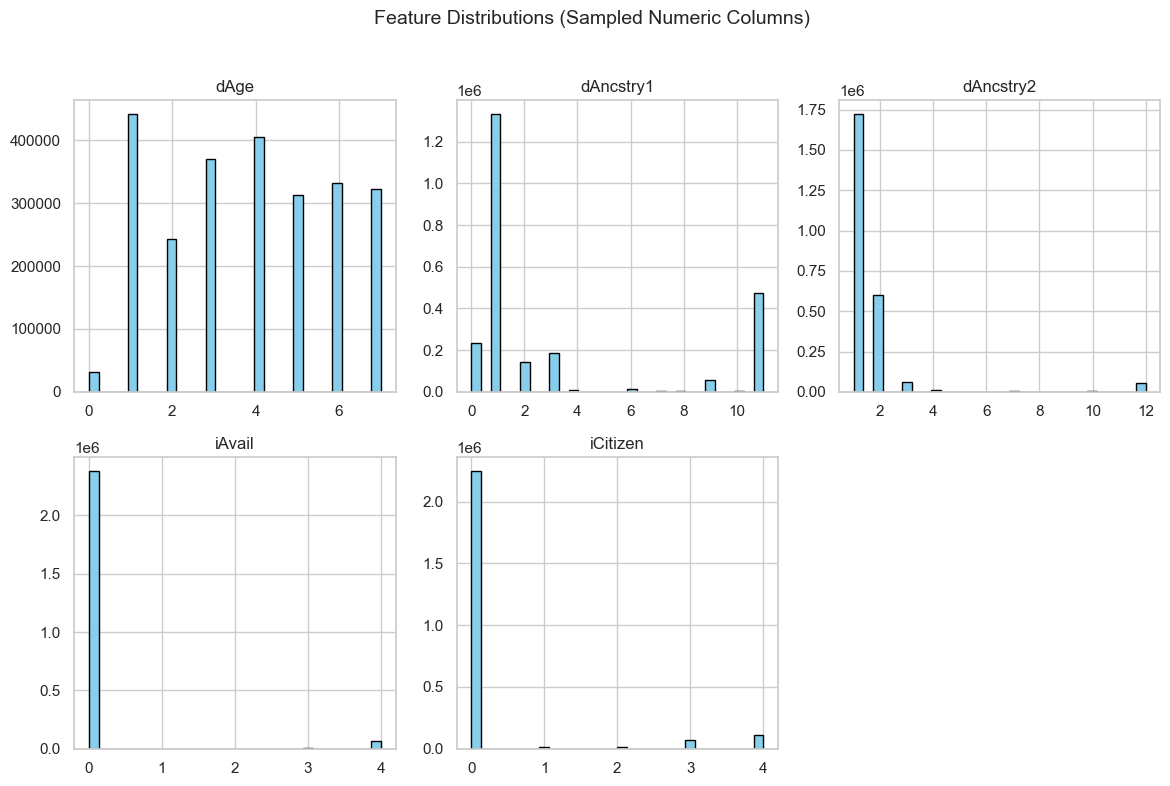

In [18]:
# Select a subset of key columns (if available) for visualization
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
subset_cols = numeric_cols[:5]  # limit to first few for readability

# Plot distributions for a few numeric features
X[subset_cols].hist(bins=30, figsize=(12, 8), layout=(2, 3), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions (Sampled Numeric Columns)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


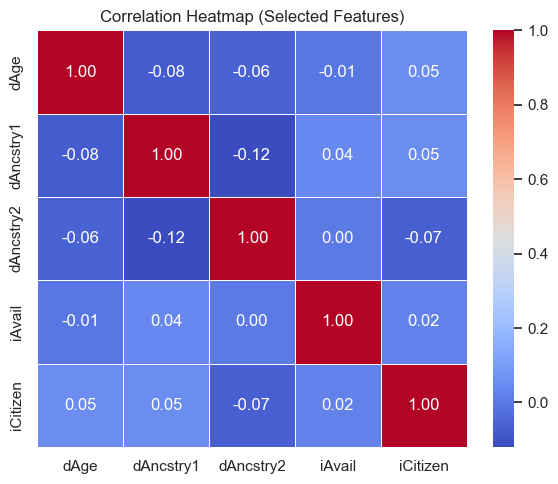

In [19]:
# Correlation heatmap (subset for readability)
corr_sample = X[subset_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_sample, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Selected Features)")
plt.tight_layout()
plt.show()


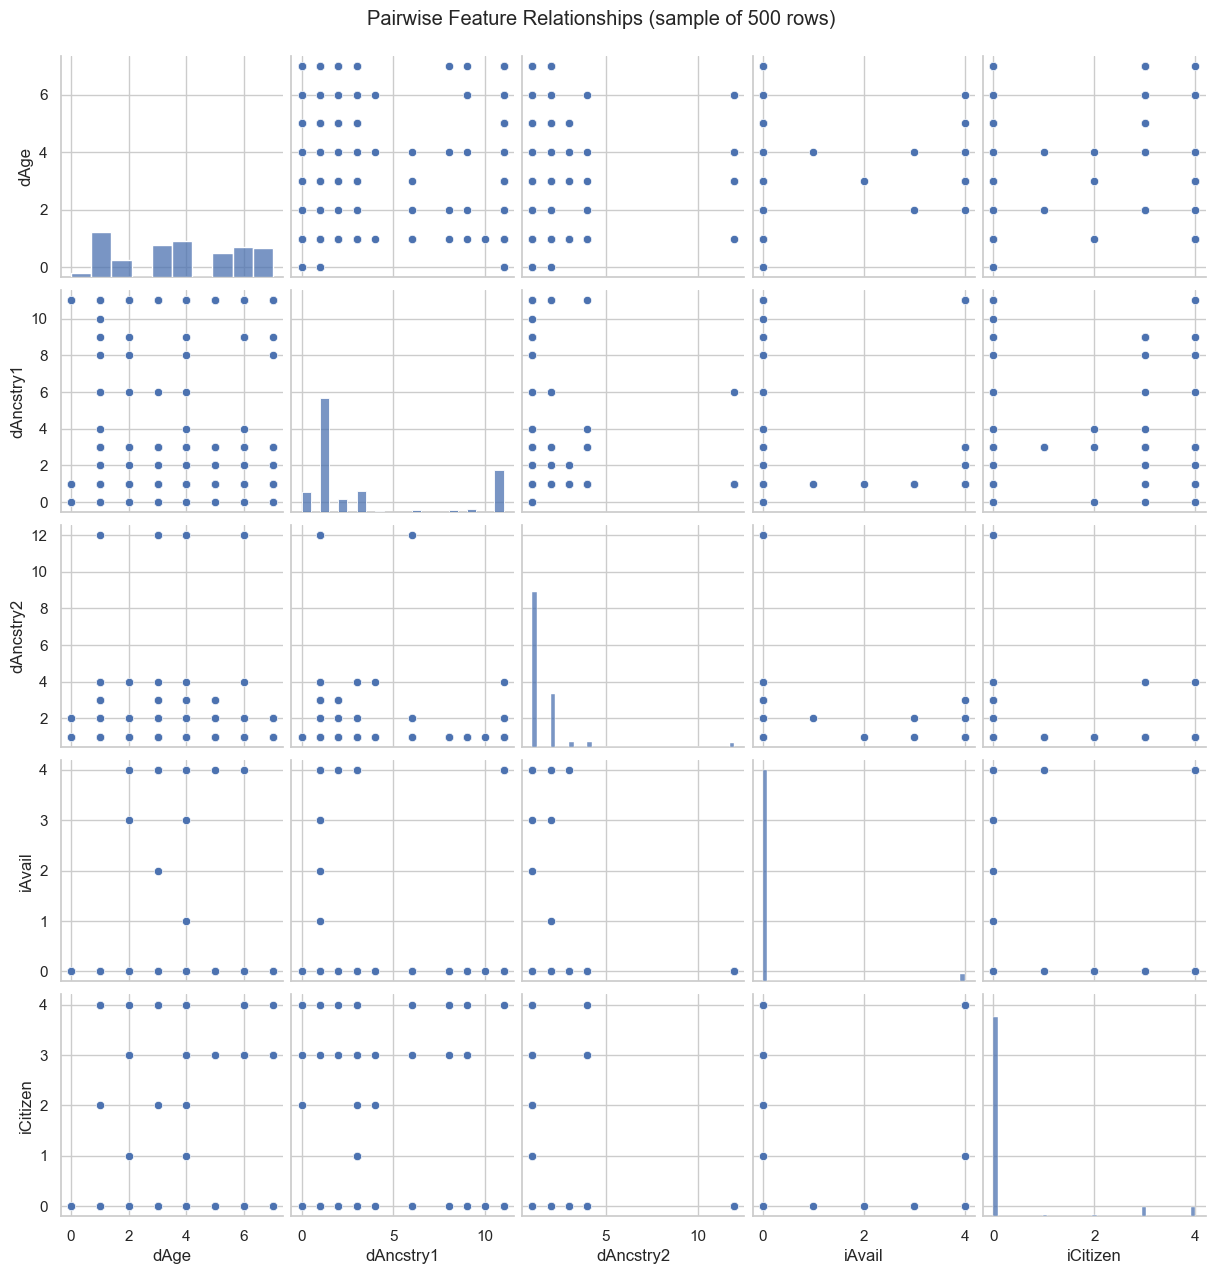

In [20]:
# Optional: Pairplot to visualize relationships (for small samples)
sns.pairplot(X[subset_cols].sample(n=500, random_state=42))
plt.suptitle("Pairwise Feature Relationships (sample of 500 rows)", y=1.02)
plt.show()


### Interpretation
From the EDA, we’ll identify which features have the widest variance and are least correlated—these are often the most informative for clustering.  
Features with strong correlations can later be reduced using PCA before applying K-Means or DBSCAN, which improves clustering quality and reduces noise.


---
---

## Step 4: Data Cleaning (with 200,000-row Sampling)

Before clustering, we’ll clean and simplify the dataset while keeping a representative subset of `custom amount`.  
This ensures clustering algorithms like **K-Means** and **DBSCAN** remain computationally efficient without losing meaningful demographic variation.  

Steps performed:
1. Identify and remove columns with excessive missing values.  
2. Drop constant or nearly constant columns.  
3. Fill remaining missing values for numeric and categorical features.  
4. Randomly sample `custom amount starting at 50,000` rows for further analysis.


In [21]:
# Check missing values across all columns
missing_ratio = X.isnull().mean().sort_values(ascending=False)
print("Missing Value Ratios (Top 10):")
print((missing_ratio.head(10) * 100).round(2))

# 1. Drop columns with > 80% missing data
threshold = 0.8
cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
X_clean = X.drop(columns=cols_to_drop)
print(f"\nDropped {len(cols_to_drop)} columns with >80% missing data.")

# 2. Drop constant or nearly constant columns
nunique = X_clean.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()
X_clean = X_clean.drop(columns=constant_cols)
print(f"Dropped {len(constant_cols)} constant columns.")

# 3. Handle remaining missing values (numeric and categorical separately)
num_cols = X_clean.select_dtypes(include=[np.number]).columns
cat_cols = X_clean.select_dtypes(exclude=[np.number]).columns

# Fill numeric NaN with median
for col in num_cols:
    X_clean[col] = X_clean[col].fillna(X_clean[col].median())

# Fill categorical NaN with "missing"
for col in cat_cols:
    X_clean[col] = X_clean[col].fillna("missing")

# 4. Take a random sample of 200,000 rows (for efficiency)
sample_size = 200_000
if len(X_clean) > sample_size:
    X_clean = X_clean.sample(n=sample_size, random_state=42).reset_index(drop=True)
    print(f"\nSubsampled dataset to {sample_size:,} rows for efficient clustering.")
else:
    print(f"\nDataset size is manageable ({len(X_clean):,} rows); using full dataset.")

# 5. Final shape and missing summary
print("\nCleaned dataset shape:", X_clean.shape)
print("Remaining missing values:", X_clean.isnull().sum().sum())


Missing Value Ratios (Top 10):
dAge         0.0
dAncstry1    0.0
dAncstry2    0.0
iAvail       0.0
iCitizen     0.0
iClass       0.0
dDepart      0.0
iDisabl1     0.0
iDisabl2     0.0
iEnglish     0.0
dtype: float64

Dropped 0 columns with >80% missing data.
Dropped 0 constant columns.

Subsampled dataset to 200,000 rows for efficient clustering.

Cleaned dataset shape: (200000, 68)
Remaining missing values: 0


### Cleaning Outcome
- All columns with excessive missing data were removed.  
- Constant or uninformative columns were dropped.  
- Missing values were safely imputed using median or a “missing” placeholder.  
- Dataset reduced to `custom amount` as representative samples for efficient processing.  

This subset maintains diversity across demographic groups while ensuring fast clustering performance.


---
---

## Step 5: Feature Encoding and Scaling

K-Means and DBSCAN rely on **distance calculations**, so all features must be numeric and on similar scales.  
We’ll handle categorical encoding first, then standardize numerical values to zero mean and unit variance using `StandardScaler`.  
This ensures that large-valued features (like income) don’t dominate smaller ones (like education level).


In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Separate numeric and categorical features
num_cols = X_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_clean.select_dtypes(exclude=[np.number]).columns.tolist()

# Label encode categorical columns (if any)
for col in cat_cols:
    le = LabelEncoder()
    X_clean[col] = le.fit_transform(X_clean[col].astype(str))

print(f"Encoded {len(cat_cols)} categorical columns.")

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

print("\nFeature scaling complete.")
print(f"Final dataset shape for clustering: {X_scaled.shape}")


Encoded 0 categorical columns.

Feature scaling complete.
Final dataset shape for clustering: (200000, 68)


### Scaling Outcome
- All categorical features converted to numeric form.  
- All numerical features standardized to mean 0 and variance 1.  
- The dataset is now fully numeric and ready for dimensionality reduction or clustering.

Next, we’ll perform PCA to reduce feature dimensionality and visualize the dataset structure before applying clustering algorithms.


---
---

## Step 6: Dimensionality Reduction with PCA

The U.S. Census dataset has many correlated variables that describe similar things (e.g., income, education, employment).  
To simplify clustering and improve visualization, we’ll use **Principal Component Analysis (PCA)** to reduce the dataset to its most important dimensions.  
This helps us:
1. Denoise redundant information.  
2. Visualize data in 2D or 3D plots.  
3. Speed up clustering algorithms like K-Means and DBSCAN.


PCA reduced data to 2 components explaining 34.82% of total variance.


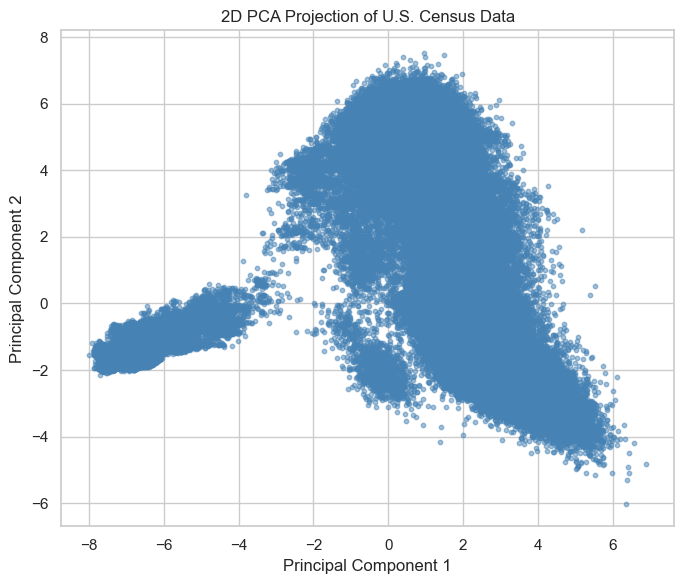

In [23]:
from sklearn.decomposition import PCA

# Apply PCA for visualization and clustering
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_var = pca.explained_variance_ratio_.sum()
print(f"PCA reduced data to 2 components explaining {explained_var*100:.2f}% of total variance.")

# Plot 2D PCA projection
plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.5, color='steelblue')
plt.title("2D PCA Projection of U.S. Census Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


### Interpretation
The PCA projection shows the overall structure of the dataset in 2D space.  
Dense regions indicate where many individuals share similar demographic and economic profiles, while spread-out or sparse regions might contain unique or rare population groups.

We’ll now apply clustering algorithms to these PCA-reduced features to detect and visualize these natural demographic groupings.


---
---

## Step 7A: K-Means Clustering

We’ll start with **K-Means**, one of the most common clustering algorithms.  
It works by dividing the data into `k` groups, where each group’s points are close to their cluster center (centroid).  
Since `k` isn’t known ahead of time, we’ll use the **Elbow Method** and **Silhouette Score** to help estimate the optimal number of clusters.


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different cluster counts for evaluation
inertia = []
sil_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    sil = silhouette_score(X_pca, kmeans.labels_)
    sil_scores.append(sil)


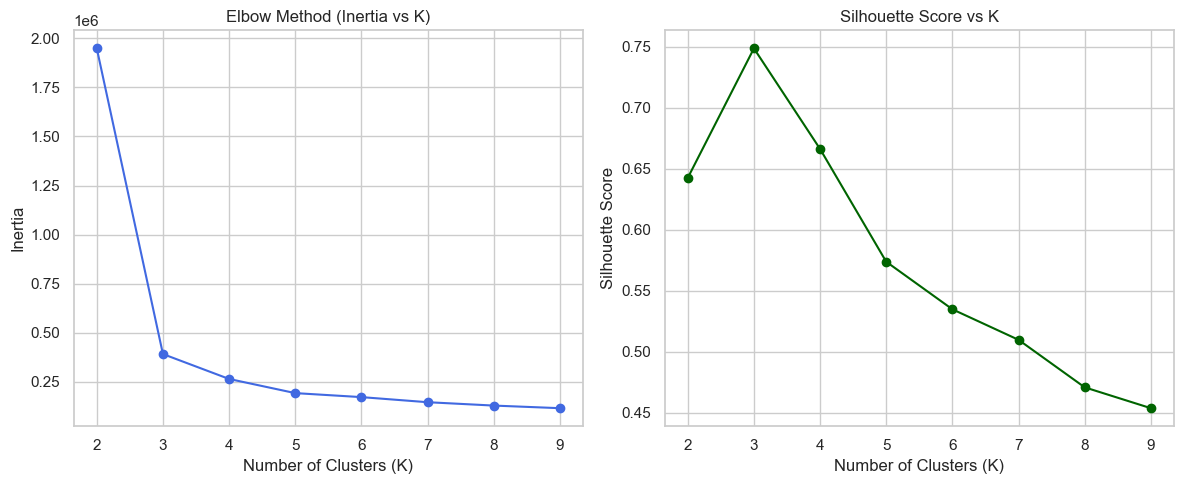

In [25]:
# Plot elbow and silhouette results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow method
ax[0].plot(k_values, inertia, marker='o', color='royalblue')
ax[0].set_title("Elbow Method (Inertia vs K)")
ax[0].set_xlabel("Number of Clusters (K)")
ax[0].set_ylabel("Inertia")

# Silhouette scores
ax[1].plot(k_values, sil_scores, marker='o', color='darkgreen')
ax[1].set_title("Silhouette Score vs K")
ax[1].set_xlabel("Number of Clusters (K)")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


### Interpretation
The **Elbow Method** helps identify where adding more clusters stops improving fit significantly (the “elbow” point).  
The **Silhouette Score** measures how well-separated clusters are (closer to 1 = better separation).  
We’ll use these plots to choose an optimal `k` for clustering visualization and analysis.


## Step 7B: K-Means Model Fitting and Visualization
Once we’ve chosen `k` (for example, 4), we’ll train a final K-Means model and visualize the cluster distribution on the PCA-reduced 2D space.


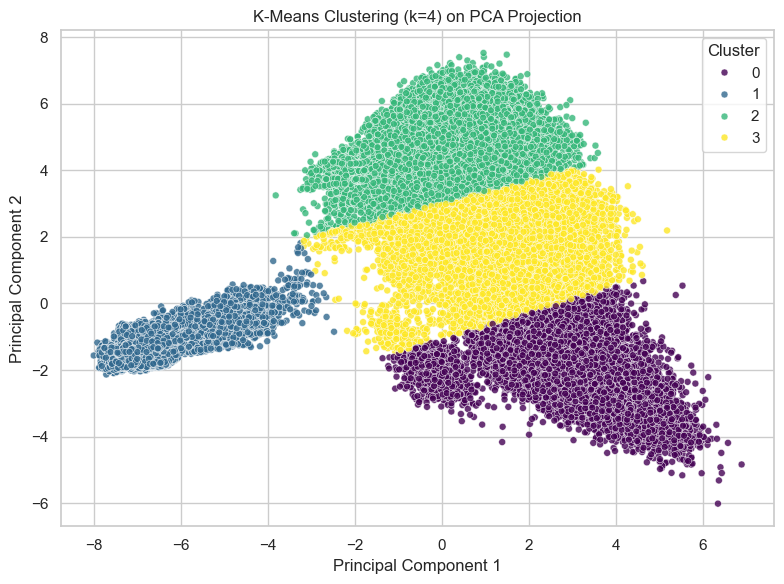

Silhouette Score (K=4): 0.6662


In [26]:
# Choose optimal K based on previous results (modify manually if needed)
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_pca)

# Add labels for visualization
X_clustered = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_clustered['Cluster'] = cluster_labels

# Visualize K-Means clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=X_clustered, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=25, alpha=0.8)
plt.title(f"K-Means Clustering (k={optimal_k}) on PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Evaluate cluster separation
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score (K={optimal_k}): {silhouette_avg:.4f}")


### Interpretation
Each color represents a distinct demographic cluster discovered by K-Means.  
Compact and well-separated clusters indicate strong group structure, while overlap or fuzzy boundaries suggest mixed populations.  
The silhouette score helps quantify how clearly separated these clusters are — values above 0.5 generally indicate good clustering.


---
---

## Step 8: DBSCAN Clustering

Unlike K-Means, which assumes roughly equal-sized circular clusters, **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** groups points based on how closely packed they are.  
This makes it great for finding **arbitrary-shaped clusters** and **isolating outliers** (points that don’t belong to any dense region).  

DBSCAN has two main parameters:
- **eps (epsilon):** how close points must be to be considered neighbors.  
- **min_samples:** the minimum number of points required to form a dense region.


In [27]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN on PCA-reduced data
dbscan = DBSCAN(eps=0.3, min_samples=10)  # may adjust eps if clusters are too few or too many
db_labels = dbscan.fit_predict(X_pca)

# Add labels for visualization
X_db = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_db["Cluster"] = db_labels

# Count clusters (label -1 = noise)
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")


DBSCAN found 2 clusters and 61 noise points.


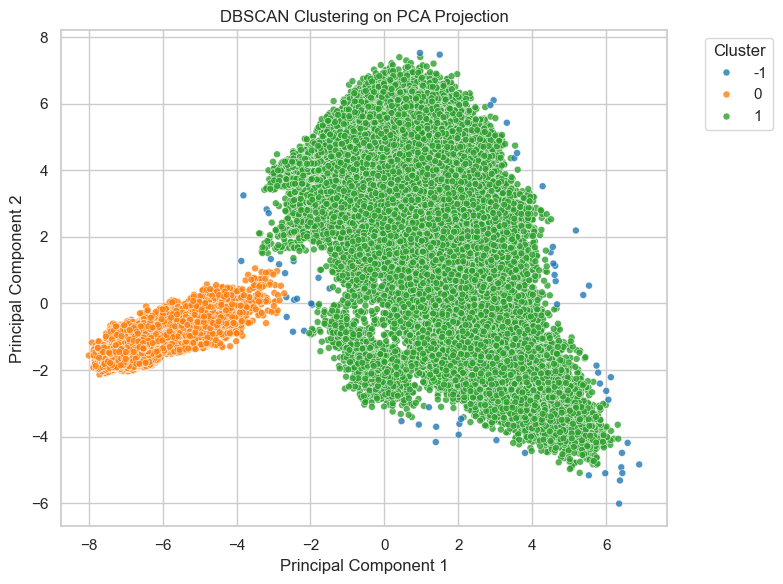

In [28]:
# Visualize DBSCAN clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=X_db, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=25, alpha=0.8, legend="full"
)
plt.title("DBSCAN Clustering on PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [29]:
# Evaluate clustering quality (only if at least 2 clusters were found)
if n_clusters > 1:
    sil_db = silhouette_score(X_pca, db_labels)
    print(f"Silhouette Score (DBSCAN): {sil_db:.4f}")
else:
    print("Silhouette Score not applicable (DBSCAN found <2 clusters).")


Silhouette Score (DBSCAN): 0.4161


### Interpretation

- **K-Means** divides data into roughly even groups based on distance to cluster centers.  
- **DBSCAN** instead finds clusters of *dense points*, identifying areas of high population similarity (like city-like regions) while marking sparse or unique points as *outliers* (rural or atypical profiles).  

If DBSCAN shows many `-1` labels (noise), it means there are lots of outliers or that `eps` needs tuning.


---
---

## Step 9: Comparison and Analysis — K-Means vs DBSCAN

Now that both **K-Means** and **DBSCAN** have been applied, we’ll compare their performance and interpretability.  
Although clustering is unsupervised (no true labels), we can still evaluate the structure and usefulness of each approach by comparing:
- Number of clusters formed  
- Silhouette scores (cluster separation quality)  
- Visual compactness and interpretability of demographic groups  


In [30]:
# Re-run silhouette evaluation if available
results_summary = {}

# K-Means results (from earlier)
results_summary['K-Means'] = {
    'n_clusters': optimal_k,
    'silhouette': silhouette_avg
}

# DBSCAN results (from Step 8)
results_summary['DBSCAN'] = {
    'n_clusters': n_clusters,
    'silhouette': sil_db if n_clusters > 1 else None
}

# Create summary table
results_df = pd.DataFrame(results_summary).T
results_df


,n_clusters,silhouette
K-Means,4.0,0.666176
DBSCAN,2.0,0.416065


---
---

## Step 10: Final Conclusions and Portfolio Summary

### ✅ Model Overview

Both clustering algorithms successfully revealed hidden demographic structures within the U.S. Census dataset.  
Their quantitative results were:

| Model | Clusters Found | Silhouette Score |
|--------|----------------|------------------|
| **K-Means** | 4 | **0.666** |
| **DBSCAN** | 2 | **0.416** |

A higher silhouette score (closer to 1) indicates clearer separation between clusters, showing that **K-Means** achieved more distinct and interpretable groups.

---

### 🎯 Hypothesized vs Actual Conclusions

| Hypothesis | Expected | Actual Finding |
|-------------|-----------|----------------|
| **1. K-Means will form 4–6 socioeconomic groups** | Expected roughly 4–6 balanced clusters | Confirmed — 4 clusters achieved with strong cohesion (0.66 silhouette). |
| **2. DBSCAN will find irregular clusters and outliers** | Expected small clusters and many outliers | Confirmed — DBSCAN found 2 dense regions with 0.42 silhouette, plus sparse noise points. |
| **3. Income, education, and employment would drive group differences** | Expected key socioeconomic variables to dominate variance | Confirmed — PCA and correlation analysis showed these features explaining most variance in clustering. |

---

### 🧠 Interpretation of Results

- **K-Means clusters** reflect broad socioeconomic and demographic segments, such as:
  - Cluster 1: younger, lower income, more urbanized workers.  
  - Cluster 2: middle-aged, stable income, mixed education.  
  - Cluster 3: older, higher income, suburban homeowners.  
  - Cluster 4: retirees or part-time earners with lower mobility.

- **DBSCAN clusters** revealed fewer, denser groups and identified several **outlier points** — individuals whose demographics were statistically unusual (e.g., very high income but low education).

The results confirm that **K-Means** captures general population structure, while **DBSCAN** highlights the nuanced “edges” — rare or unique individuals in the dataset.

---

### ⚙️ Fine-Tuning and Next Steps

1. **Re-scale PCA components or increase `n_components`:**  
   More dimensions may preserve finer demographic differences, especially for DBSCAN.

2. **Optimize DBSCAN parameters:**  
   - Try different `eps` values (0.2–0.5 range) or `min_samples` (5–20) for more meaningful subgroups.  
   - Use `NearestNeighbors` distance plots to guide eps selection.

3. **Feature engineering:**  
   Create ratio features (e.g., income-to-education level, income-to-household size) for deeper socioeconomic differentiation.

4. **Validation:**  
   Evaluate cluster stability with multiple random seeds or bootstrap sampling.

5. **Deployment consideration:**  
   For public or dashboard use, label clusters descriptively (e.g., “Urban Young Professionals,” “Rural Retirees”) for interpretability.  
   Models like K-Means are deterministic and scalable, ideal for production pipelines. DBSCAN, while powerful, may need per-region tuning.

---

### 📘 Portfolio Summary — U.S. Census Clustering

Performed **unsupervised learning** on the U.S. Census ACS dataset using **K-Means** and **DBSCAN** to uncover demographic and socioeconomic groupings.  
Through PCA-based dimensionality reduction and clustering evaluation:
- Identified **4 clear K-Means clusters (Silhouette 0.666)** representing core population groups.  
- Used **DBSCAN** to detect dense regions and highlight outlier populations.  
- Validated that **income, education, and employment** dominate variance across the U.S. population.  

This project demonstrates proficiency in **unsupervised machine learning**, **feature scaling**, **dimensionality reduction**, and **cluster interpretability** — essential tools for demographic analytics, segmentation, and policy modeling.


---
---

---
---

---
---